In [86]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

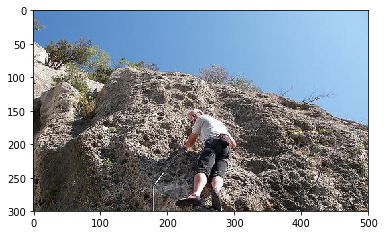

In [171]:
import numpy as np 
import matplotlib.pyplot as plt 

img = plt.imread('resized_images/wide/2.jpg') 
plt.imshow(img)
plt.show()

In [172]:
img = img.T

In [173]:
img = np.expand_dims(img, axis=0)

In [174]:
torch.tensor(img).shape

torch.Size([1, 3, 500, 300])

In [177]:
y = model(torch.tensor(img).type('torch.FloatTensor'))

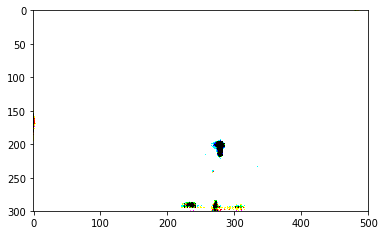

In [182]:
img_out = y.detach().numpy()
plt.imshow(img_out[0].T)
plt.show()

In [243]:
from torchvision import datasets, transforms, utils

class ImageFolder(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolder, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_index = (original_tuple + (index,))
        return tuple_with_index

class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)
    
traindir_A = 'resized_images_copy'
traindir_B = 'watermarked_image_copy'
train_loader = torch.utils.data.DataLoader(
             ConcatDataset(
                 datasets.ImageFolder(traindir_A, transform=transform),
                 datasets.ImageFolder(traindir_B, transform=transform)
             ),shuffle=False)

transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data_dir = 'resized_images_copy'
data_set_original = ImageFolder(data_dir, transform=transform)
data_loader_original = torch.utils.data.DataLoader(data_set_original, shuffle=False)

data_dir = 'watermarked_image_copy'
data_set_watermark = ImageFolder(data_dir, transform=transform)
data_loader_watermark = torch.utils.data.DataLoader(data_set_watermark, shuffle=False)


print(len(data_loader_original))
print(len(data_loader_watermark))
print(len(train_loader))

1375
1375
1375


In [186]:
from torch import nn

In [187]:
class AutoencoderConv(nn.Module):
    def __init__(self):
        super(AutoencoderConv, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [188]:
model = AutoencoderConv()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


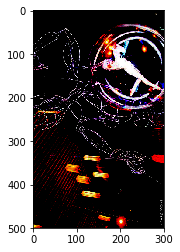

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


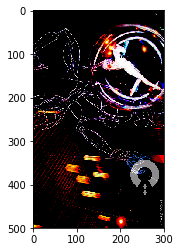

In [237]:
original,watermarked = next(iter(train_loader))
img_orig = original[0].detach().numpy()
plt.imshow(img_orig[0].T)
plt.show()

img_watermarked = watermarked[0].detach().numpy()
plt.imshow(img_watermarked[0].T)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0])


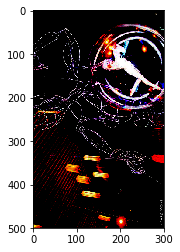

In [218]:
img,label,index = next(iter(data_loader_original))
print(index)
img_orig = img.detach().numpy()
plt.imshow(img_orig[0].T)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0])


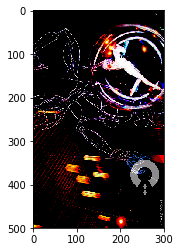

In [220]:
img, label,index  = next(iter(data_loader_watermark))
print(index)
img_orig = img.detach().numpy()
plt.imshow(img_orig[0].T)
plt.show()

In [239]:
out = model(watermarked[0])

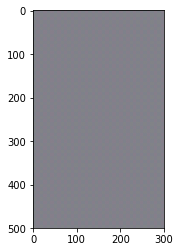

In [240]:
img_out = out.detach().numpy()
plt.imshow(img_out[0].T)
plt.show()

In [246]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    transform = transforms.Compose(
                [transforms.ToTensor(),
                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    traindir_A = 'resized_images_copy'
    traindir_B = 'watermarked_image_copy'
    train_loader = torch.utils.data.DataLoader(
                 ConcatDataset(
                     datasets.ImageFolder(traindir_A, transform=transform),
                     datasets.ImageFolder(traindir_B, transform=transform)
                 ),shuffle=False)
    
    outputs = []
    for epoch in range(num_epochs):
        for original, watermarked in train_loader:
            original_img, _ = original
            watermarked_img, _ = watermarked
            recon = model(watermarked_img)
            loss = criterion(recon, original_img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, original_img, recon),)
    return outputs

In [ ]:
max_epochs =10
outputs = train(model, num_epochs=max_epochs)

Epoch:1, Loss:0.4596
Epoch:2, Loss:0.4527


In [ ]:
for k in range(0, max_epochs, 5):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])